# CS363D Group 16 Project
- Jason Causey
- Mei Lin
- Sonya Pieklik
- Thomas Budiman

### Analysing Google Play Store Applications

Our goal is to predict whether an app has a good rating or bad rating using features such as the category where the app belongs, the type of the application, whether it's free or paid, number of times the application has been installed from the Play Store, content rating for the app, how recent since the app is updated, number of reviews made for the app on the Play Store, and app's size itself.

A good rating is considered to have a score of 4.2 out of a 5 point mark, otherwise, it is a bad rating. Predicting whether an app has a good or bad rating may help us analyze the efficacy and corret use cases for these applications. With this analysis, it will allow customers and potential users to decide more quickly and decisively in which applications they would want to download. By being able to predict which applications have a quality ranking will allows customers to save time in finding exactly what type of tools they need.

### Imports

These are standard headers and imports that we will be using for the project. More additional imports are also added later in the notebook where appropriate.

In [34]:
import warnings
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

import time
from datetime import date

pd.__version__ #print which version of pandas you're using

'1.3.5'

### Dataset
Here's the link to dataset: https://www.kaggle.com/datasets/lava18/google-play-store-apps

This data set details each applications on the Google Play Store.

We first read in our data set into a pandas DataFrame and print out the first few entries of our dataframe.

In [35]:
data = pd.read_csv("googleplaystore.csv")
print("dataset shape:",data.shape)
data.head()

dataset shape: (10841, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Data Preprocessing & Exploration

We would first need to prepare our data before we can use it to train on and build our model.

The steps we have taken below includes removing erroneous data; feature enginerring, such as feature selection, feature creation, converting the data to the correct format and datatype; removing missing values; and encoding categorical data into numerical features.



**Erroneous Data**

We found an erroneous data that has different values for all the features compared to other records in the data set, so we decide to discard it.

In [36]:
print(data.iloc[10472]) # lots of errors in this entry (outlier)
clean_data = data.drop(data.index[10472]) # delete

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                               19.0
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                  February 11, 2018
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object


## Feature Engineering

### Convert Features Data Types

Some values such as 3.0M is stored as object type instead of 3000000 as numeric values.

Below we search and convert all supposedly numeric values into actual numeric data types

#### Reviews, Size, Installs Features

The `Reviews` feature values are converted directing to numerical values using `pd.to_numeric` function.

The `Size` feature contains values representing the size of the applications with varying units such as megabytes (e.g., "3.0M") and kilobytes (e.g., "3.0k"). We replace the value respectively so that the final values stored for `Size` features are in bytes.

The `Installs` feature represents the number of installs for the application when the data was scraped. However, this is not the exact number of installs, rather, it is the storing the number of installs it has surpassed. Hence, we convert "3,000+" into "3000" and assume the number to the the literal number of installs.

In [37]:
# fix reviews column
reviews = pd.to_numeric(clean_data['Reviews'])
clean_data['Reviews'] = reviews

# fix size column
factor = clean_data['Size'].astype(str).str.extract(r'[\d\.]+([kM]+)', expand=False).fillna(1).replace(['k','M'], [10**3, 10**6]).astype(int)
# TODO: replace 'Varies with device' values
size = clean_data['Size'].replace({'Varies with device':'NaN'})
size = size.replace(r'[kM]+$','',regex=True).astype(float) * factor
clean_data['Size'] = size

# fix installs column
installs = clean_data['Installs'].replace(r'[\+]+$','',regex=True) # replaces '1,000+' to just '1,000'
installs = installs.astype(str).str.replace(',', '').astype(float) # replaces '1,000' to '1000'
clean_data['Installs'] = installs

print(clean_data.dtypes)
print(clean_data.shape)
clean_data.head()

App                object
Category           object
Rating            float64
Reviews             int64
Size              float64
Installs          float64
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object
(10840, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,10000.0,Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000.0,Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000.0,5000000.0,Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000.0,50000000.0,Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000.0,100000.0,Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


### Feature Creation 

**Create a new feature from date**

Since the `Last Updated` feature is not really a numerical feature, we decided to use that feature to create a new feature that indicates the recency of the application. In other words, we used the 'Last Updated' dates to calculate how many days has it been since the application is last updated. 

This new feature is labeled as `Days` in our data set.

In [38]:
# fix date column ?
# datetime object
dates = pd.to_datetime(clean_data['Last Updated'], format='%B %d, %Y')
clean_data['Last Updated'] = dates
last_updated = clean_data['Last Updated']

def calculate_days(date):
    today = pd.Timestamp('today')
    return (today - date).days

days_col = last_updated.apply(lambda x: calculate_days(x))
days_col.head()
clean_data['Days'] = days_col
clean_data = clean_data.drop('Last Updated', axis='columns')
clean_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Current Ver,Android Ver,Days
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,10000.0,Free,0,Everyone,Art & Design,1.0.0,4.0.3 and up,1569
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000.0,Free,0,Everyone,Art & Design;Pretend Play,2.0.0,4.0.3 and up,1561
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000.0,5000000.0,Free,0,Everyone,Art & Design,1.2.4,4.0.3 and up,1363
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000.0,50000000.0,Free,0,Teen,Art & Design,Varies with device,4.2 and up,1417
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000.0,100000.0,Free,0,Everyone,Art & Design;Creativity,1.1,4.4 and up,1405


### Discarding Missing Values
We first determine which columns contain missing values and the number of missing values for each column.

In [39]:
clean_data.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size              1695
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Current Ver          8
Android Ver          2
Days                 0
dtype: int64

We decided to remove all missing-value records in our data set since we have about more than 10,000 instances and would still have more than 7700 instances after removing them.

In [40]:
clean_data = clean_data.loc[clean_data.Rating.notna()]
clean_data = clean_data.loc[clean_data.Size.notna()]
print(clean_data.shape)
print(clean_data.isna().sum())

(7729, 13)
App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Current Ver       4
Android Ver       2
Days              0
dtype: int64


### Encoding Categorical Data

#### Binning Class Label

We bin the `Rating` column into zeros and ones in which any rating greater than 4.2 is 1 (or good) and anything less or equal to 4.2 is 0 (or bad).

In [41]:
# Bin Rating
clean_data['Rating'].values[clean_data['Rating'].values <= 4.2] = 0
clean_data['Rating'].values[clean_data['Rating'].values > 4.2] = 1

#### Encode Type Feature

The `Type` feature describes whether an application is a free application or a paid application. Since the values are binary, we encode the value into zero for "Free" and one for "Paid".

In [42]:
# encode Type column from "Free" & "Paid" to 0 and 1
new_type = clean_data['Type'].replace({"Free": 0, "Paid": 1})
clean_data['Type'] = new_type

print(clean_data.shape)
print(clean_data.dtypes)
clean_data.head()

(7729, 13)
App                object
Category           object
Rating            float64
Reviews             int64
Size              float64
Installs          float64
Type                int64
Price              object
Content Rating     object
Genres             object
Current Ver        object
Android Ver        object
Days                int64
dtype: object


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Current Ver,Android Ver,Days
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,0.0,159,19000000.0,10000.0,0,0,Everyone,Art & Design,1.0.0,4.0.3 and up,1569
1,Coloring book moana,ART_AND_DESIGN,0.0,967,14000000.0,500000.0,0,0,Everyone,Art & Design;Pretend Play,2.0.0,4.0.3 and up,1561
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,1.0,87510,8700000.0,5000000.0,0,0,Everyone,Art & Design,1.2.4,4.0.3 and up,1363
3,Sketch - Draw & Paint,ART_AND_DESIGN,1.0,215644,25000000.0,50000000.0,0,0,Teen,Art & Design,Varies with device,4.2 and up,1417
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,1.0,967,2800000.0,100000.0,0,0,Everyone,Art & Design;Creativity,1.1,4.4 and up,1405


#### Encode Content Rating

The `Content Rating` has 6 unique values that we use scikit-learn's OneHotEncoder to produce 6 new columns for each value. We merge the 6 new features to our dataset and removed the original, categorical `Content Rating` feature.

In [43]:
# TODO: Encode Content Rating
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
rating_ftx = ohe.fit_transform(clean_data[['Content Rating']]).toarray()
rating_hdr = np.array(ohe.categories_).ravel()

new_rating = pd.DataFrame(rating_ftx,columns=rating_hdr)
print(new_rating.shape)
print(new_rating.head())
clean_data = pd.concat([clean_data.reset_index(drop=True), new_rating.reset_index(drop=True)], axis=1)
clean_data = clean_data.drop('Content Rating', axis='columns')

print(clean_data.dtypes)
print(clean_data.shape)
clean_data.head()

(7729, 6)
   Adults only 18+  Everyone  Everyone 10+  Mature 17+  Teen  Unrated
0              0.0       1.0           0.0         0.0   0.0      0.0
1              0.0       1.0           0.0         0.0   0.0      0.0
2              0.0       1.0           0.0         0.0   0.0      0.0
3              0.0       0.0           0.0         0.0   1.0      0.0
4              0.0       1.0           0.0         0.0   0.0      0.0
App                 object
Category            object
Rating             float64
Reviews              int64
Size               float64
Installs           float64
Type                 int64
Price               object
Genres              object
Current Ver         object
Android Ver         object
Days                 int64
Adults only 18+    float64
Everyone           float64
Everyone 10+       float64
Mature 17+         float64
Teen               float64
Unrated            float64
dtype: object
(7729, 18)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Genres,Current Ver,Android Ver,Days,Adults only 18+,Everyone,Everyone 10+,Mature 17+,Teen,Unrated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,0.0,159,19000000.0,10000.0,0,0,Art & Design,1.0.0,4.0.3 and up,1569,0.0,1.0,0.0,0.0,0.0,0.0
1,Coloring book moana,ART_AND_DESIGN,0.0,967,14000000.0,500000.0,0,0,Art & Design;Pretend Play,2.0.0,4.0.3 and up,1561,0.0,1.0,0.0,0.0,0.0,0.0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,1.0,87510,8700000.0,5000000.0,0,0,Art & Design,1.2.4,4.0.3 and up,1363,0.0,1.0,0.0,0.0,0.0,0.0
3,Sketch - Draw & Paint,ART_AND_DESIGN,1.0,215644,25000000.0,50000000.0,0,0,Art & Design,Varies with device,4.2 and up,1417,0.0,0.0,0.0,0.0,1.0,0.0
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,1.0,967,2800000.0,100000.0,0,0,Art & Design;Creativity,1.1,4.4 and up,1405,0.0,1.0,0.0,0.0,0.0,0.0


#### Encode Category Feature

The `Category` Feature classifies each application into categories. There are 33 unique values for this feature and we decided to Label Encode each unique value with a numeric value.

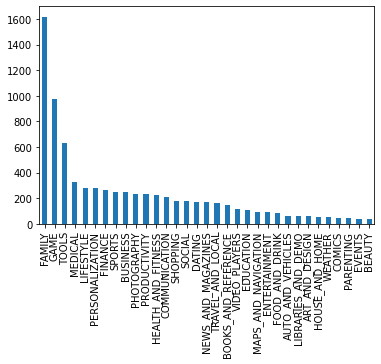

In [44]:
clean_data['Category'].value_counts().plot(kind="bar")

In [45]:
# TODO Encode Category
new_type = clean_data['Category'].replace({"FAMILY": 0.0, "GAME": 1.0, "TOOLS": 2.0, "MEDICAL": 3.0,
                                          "LIFESTYLE": 4.0, "PERSONALIZATION": 5.0, "FINANCE": 6.0, "SPORTS": 7.0,
                                          "BUSINESS": 8.0, "PHOTOGRAPHY": 9.0, "PRODUCTIVITY": 10.0, "HEALTH_AND_FITNESS": 11.0,
                                          "COMMUNICATION": 12.0, "SHOPPING": 13.0, "SOCIAL": 14.0, "DATING": 15.0,
                                          "NEWS_AND_MAGAZINES": 16.0, "TRAVEL_AND_LOCAL": 17.0, "BOOKS_AND_REFERENCE": 18.0, "VIDEO_PLAYERS": 19.0,
                                          "EDUCATION": 20.0, "MAPS_AND_NAVIGATION": 21.0, "ENTERTAINMENT": 22.0, "FOOD_AND_DRINK": 23.0,
                                          "AUTO_AND_VEHICLES": 24.0, "LIBRARIES_AND_DEMO": 25.0, "ART_AND_DESIGN": 26.0, "HOUSE_AND_HOME": 27.0,
                                          "WEATHER": 28.0, "COMICS": 29.0, "PARENTING": 30.0, "EVENTS": 31.0, "BEAUTY": 32.0})
clean_data['Category'] = new_type

print(clean_data.dtypes)
clean_data.head()

App                 object
Category           float64
Rating             float64
Reviews              int64
Size               float64
Installs           float64
Type                 int64
Price               object
Genres              object
Current Ver         object
Android Ver         object
Days                 int64
Adults only 18+    float64
Everyone           float64
Everyone 10+       float64
Mature 17+         float64
Teen               float64
Unrated            float64
dtype: object


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Genres,Current Ver,Android Ver,Days,Adults only 18+,Everyone,Everyone 10+,Mature 17+,Teen,Unrated
0,Photo Editor & Candy Camera & Grid & ScrapBook,26.0,0.0,159,19000000.0,10000.0,0,0,Art & Design,1.0.0,4.0.3 and up,1569,0.0,1.0,0.0,0.0,0.0,0.0
1,Coloring book moana,26.0,0.0,967,14000000.0,500000.0,0,0,Art & Design;Pretend Play,2.0.0,4.0.3 and up,1561,0.0,1.0,0.0,0.0,0.0,0.0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",26.0,1.0,87510,8700000.0,5000000.0,0,0,Art & Design,1.2.4,4.0.3 and up,1363,0.0,1.0,0.0,0.0,0.0,0.0
3,Sketch - Draw & Paint,26.0,1.0,215644,25000000.0,50000000.0,0,0,Art & Design,Varies with device,4.2 and up,1417,0.0,0.0,0.0,0.0,1.0,0.0
4,Pixel Draw - Number Art Coloring Book,26.0,1.0,967,2800000.0,100000.0,0,0,Art & Design;Creativity,1.1,4.4 and up,1405,0.0,1.0,0.0,0.0,0.0,0.0


### Features Selection

The following are the process of dropping columns or features that would not be useful in the analysis and model training of our data set.

We decided to drop several features such as `Genres`, `Price`, `App`, `Current Ver`, and `Android Ver`.

#### **Genres** Feature

The `Genres` feature describes the subcategory each application belongs to and some applications can belong to multiple genres. Since we had a more general, `Category` feature, we decided to drop the `Genres` feature because it is not adding any novel information to improve our model.

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Current Ver,Android Ver,Days,Adults only 18+,Everyone,Everyone 10+,Mature 17+,Teen,Unrated
0,Photo Editor & Candy Camera & Grid & ScrapBook,26.0,0.0,159,19000000.0,10000.0,0,0,1.0.0,4.0.3 and up,1569,0.0,1.0,0.0,0.0,0.0,0.0
1,Coloring book moana,26.0,0.0,967,14000000.0,500000.0,0,0,2.0.0,4.0.3 and up,1561,0.0,1.0,0.0,0.0,0.0,0.0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",26.0,1.0,87510,8700000.0,5000000.0,0,0,1.2.4,4.0.3 and up,1363,0.0,1.0,0.0,0.0,0.0,0.0
3,Sketch - Draw & Paint,26.0,1.0,215644,25000000.0,50000000.0,0,0,Varies with device,4.2 and up,1417,0.0,0.0,0.0,0.0,1.0,0.0
4,Pixel Draw - Number Art Coloring Book,26.0,1.0,967,2800000.0,100000.0,0,0,1.1,4.4 and up,1405,0.0,1.0,0.0,0.0,0.0,0.0


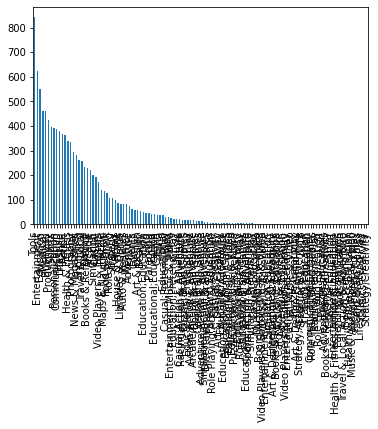

In [46]:
data['Genres'].value_counts().plot(kind="bar")
clean_data = clean_data.drop('Genres', axis='columns')
clean_data.head()

#### **Price** Feature

For `Price` feature, we decided to drop that feature because we already have the application `type` feature that defines if the app is paid or free. Since the majority of applications on the google play store are free, including the `Price` feature does not necessarily improve our model accuracy significantly. 

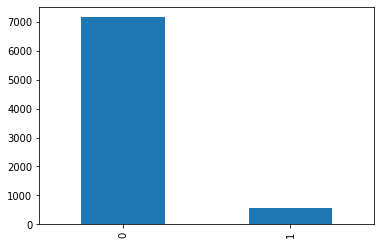

In [47]:
clean_data['Type'].value_counts().plot(kind="bar")

The above graph visualizes the number of applications in the Google Play Store that are free and paid. There are about ...

In [48]:
clean_data = clean_data.drop('Price', axis='columns')

#### App, Current Ver, Android Ver Features

The `App` Feature is basically the name of the application, which we decide to drop because it will not be applicable for training our models.

The `Current Ver` and `Android Ver` dictates the current version number of the application and the minimum Android operating system version that the application supports. The `Current Ver` feature is subjective. The `Android Ver` may show the application's recency factor, but the `Last Updated` feature better represents it. Thus, we decided to also drop these two features.

In [49]:
clean_data = clean_data.drop('App', axis='columns')
clean_data = clean_data.drop('Current Ver', axis='columns')
clean_data = clean_data.drop('Android Ver', axis='columns')
clean_data.head()

,Category,Rating,Reviews,Size,Installs,Type,Days,Adults only 18+,Everyone,Everyone 10+,Mature 17+,Teen,Unrated
0,26.0,0.0,159,19000000.0,10000.0,0,1569,0.0,1.0,0.0,0.0,0.0,0.0
1,26.0,0.0,967,14000000.0,500000.0,0,1561,0.0,1.0,0.0,0.0,0.0,0.0
2,26.0,1.0,87510,8700000.0,5000000.0,0,1363,0.0,1.0,0.0,0.0,0.0,0.0
3,26.0,1.0,215644,25000000.0,50000000.0,0,1417,0.0,0.0,0.0,0.0,1.0,0.0
4,26.0,1.0,967,2800000.0,100000.0,0,1405,0.0,1.0,0.0,0.0,0.0,0.0


Our data preparation/data cleaning is complete and our data is now ready for use.

In [50]:
clean_data.dtypes

Category           float64
Rating             float64
Reviews              int64
Size               float64
Installs           float64
Type                 int64
Days                 int64
Adults only 18+    float64
Everyone           float64
Everyone 10+       float64
Mature 17+         float64
Teen               float64
Unrated            float64
dtype: object


### Data Prep for Scikit Learn

All of the classifiers in scikit-learn require that we separate the feature columns from the class label column. We have two separate data frames: one that contains all of the feature values `features_df` and one that contains the class labels `labels_df`.

The shape of your features data frame, the shape or len of your labels dataframe or array, and the head of the features data frame are printed below.



In [51]:
features_df = clean_data.iloc[:,clean_data.columns != 'Rating']
labels_df = clean_data.iloc[:,clean_data.columns == 'Rating'].values.ravel()

print("features dataframe shape:", features_df.shape)
print(features_df.head())

print("labels dataframe shape: ", labels_df.shape)
print("labels head:", labels_df)

features dataframe shape: (7729, 12)
   Category  Reviews        Size    Installs  Type  Days  Adults only 18+  \
0      26.0      159  19000000.0     10000.0     0  1569              0.0   
1      26.0      967  14000000.0    500000.0     0  1561              0.0   
2      26.0    87510   8700000.0   5000000.0     0  1363              0.0   
3      26.0   215644  25000000.0  50000000.0     0  1417              0.0   
4      26.0      967   2800000.0    100000.0     0  1405              0.0   

   Everyone  Everyone 10+  Mature 17+  Teen  Unrated  
0       1.0           0.0         0.0   0.0      0.0  
1       1.0           0.0         0.0   0.0      0.0  
2       1.0           0.0         0.0   0.0      0.0  
3       0.0           0.0         0.0   1.0      0.0  
4       1.0           0.0         0.0   0.0      0.0  
labels dataframe shape:  (7729,)
labels head: [0. 0. 1. ... 1. 1. 1.]


## Model 1: Decision Trees (DT) 

### Using train_test_split
We first try to build a DT by training a classfier using the holdout method by splitting our data into a training set and a test set, then evaluate the classifier on the held-out test set.

We split the data "manually" using scikit-learn's `train_test_split`

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


def calc_accuracy_dt (clf) :
    clf = clf.fit(features_train, labels_train)
    # predict 
    pred = clf.predict(features_test)
    # accuracy
    print("accuracy:", accuracy_score(labels_test, pred))

# Split data into test and train
print("dataset size:", features_df.shape[0])
test_len = features_df.shape[0] // 5
train_len = features_df.shape[0] - test_len
features_train, features_test, labels_train, labels_test = train_test_split(features_df, labels_df, train_size=train_len, test_size=test_len)
print("feature test set size:", features_test.shape)
print("feature train set size:", features_train.shape)
print("labels test set size:", labels_test.shape)
print("labels train set size:", labels_train.shape)


# Build Decision tree and calculate accuracy
clf = DecisionTreeClassifier(criterion='entropy')
calc_accuracy_dt(clf)

dataset size: 7729
feature test set size: (1545, 12)
feature train set size: (6184, 12)
labels test set size: (1545,)
labels train set size: (6184,)
accuracy: 0.6233009708737864


DecisionTree classifier has many parameters that can be set. The code below is where we tweak/tune parameters like split criterion, max_depth, min_impurity_decrease, min_samples_leaf, min_samples_split, etc. to see how they affect accuracy. The accuracy of a few different variations are printed with the indicated parameter.

In [53]:
# your code goes here
# Decision tree
clf = DecisionTreeClassifier(criterion='gini')
print("criterion: gini")
calc_accuracy_dt(clf)

# entropy, max_depth=4
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)
print("\ncriterion: entropy, max_depth=4")
calc_accuracy_dt(clf)
# entropy, max_depth=8
clf = DecisionTreeClassifier(criterion='entropy', max_depth=8)
print("criterion: entropy, max_depth=8")
calc_accuracy_dt(clf)


# entropy, min_impurity_decrease=1
clf = DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=1)
print("\ncriterion: entropy, min_impurity_decrease=1")
calc_accuracy_dt(clf)
# entropy, min_impurity_decrease=0.001
clf = DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.001)
print("criterion: entropy, min_impurity_decrease=0.001")
calc_accuracy_dt(clf)

# entropy, min_samples_leaf=3
clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3)
print("\ncriterion: entropy, min_samples_leaf=3")
calc_accuracy_dt(clf)
# entropy, min_samples_leaf=2
clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2)
print("criterion: entropy, min_samples_leaf=2")
calc_accuracy_dt(clf)


# entropy, min_samples_split=2
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=2)
print("\ncriterion: entropy, min_samples_split=2")
calc_accuracy_dt(clf)
# entropy, min_samples_split=3
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=3)
print("criterion: entropy, min_samples_split=3")
calc_accuracy_dt(clf)
# entropy, min_samples_split=5
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=5)
print("criterion: entropy, min_samples_split=5")
calc_accuracy_dt(clf)

criterion: gini
accuracy: 0.6297734627831715

criterion: entropy, max_depth=4
accuracy: 0.6122977346278318
criterion: entropy, max_depth=8
accuracy: 0.6336569579288026

criterion: entropy, min_impurity_decrease=1
accuracy: 0.5300970873786408
criterion: entropy, min_impurity_decrease=0.001
accuracy: 0.6427184466019418

criterion: entropy, min_samples_leaf=3
accuracy: 0.6310679611650486
criterion: entropy, min_samples_leaf=2
accuracy: 0.6226537216828479

criterion: entropy, min_samples_split=2
accuracy: 0.6213592233009708
criterion: entropy, min_samples_split=3
accuracy: 0.6226537216828479
criterion: entropy, min_samples_split=5
accuracy: 0.6200647249190938


We now have more knowledge of how the parameters for our decision tree will affect the accuracy of our model.

However, the algorithm to generate the decision tree is only run once, which is not sufficient to estimate the generalization accuracy. Thus, we know perform Cross Validation using `cross_val_score` with a 10-fold-cv to get a better estimate of the accuracy of the model. 

In [54]:
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_impurity_decrease=0.001, min_samples_leaf=2, min_samples_split=3)
score = cross_val_score(clf, features_df, labels_df, cv=10)
print("Decision Tree with using entropy criterion, max_depth 8, min_impurity_decrease 0.001, min_samples_leaf 2, min_samples_split 3")
print("average accuracy:",score.mean())

Decision Tree with using entropy criterion, max_depth 8, min_impurity_decrease 0.001, min_samples_leaf 2, min_samples_split 3
average accuracy: 0.5920558821360824


Note that this whole approach is a "manual" way of finding the best parameters. We are not guaranteed that these are the best parameters or the best combination of parameters. Through this however, we can learn more about the range of the parameters to perform trial and error on when we use a more methodical approach below.

## Using cross_val_score and Nested Cross Validation

Previously we "manually" split the dataset and "manually" tune the parameters for our decision tree, choosing what we think is best for our model. However, this does not guarantees the best parameters and the best accuracy.

To produce our **final decision tree model**, however, we want to use the best parameters to avoid overfitting our training data. Thus, we use the Grid Search approach to tune our parameters methodically that builds and evaluates a model for each combination of hyperparameters specified in a grid. 

We use `sklearn.model_selection.GridSearchCV` to find the best `criterion`, `max_depth`, `max_features`, `min_samples_leaf`, and `min_samples_split` for our tree. Along with a 5-fold-CV and 'accuracy' for the scoring criteria.

The best parameters are printed below along with the accuracy of the model with these "best" parameters.

In [55]:
from sklearn.model_selection import GridSearchCV
clf = DecisionTreeClassifier()
parameters = {'criterion': ['entropy', 'gini'],
              'max_depth': [5, 10, 15, 20], 
              'min_samples_leaf': [5, 10, 15, 20],
              'max_features': [5, 10, 12],
              'min_samples_split': [2, 3, 5],
              'min_impurity_decrease': [0.001, 0.1, 1]}
gscv = GridSearchCV(clf, parameters, scoring='accuracy', cv=5)
gscv.fit(features_df,labels_df)
print("Best parameters for our DT:", gscv.best_params_)
print("average accuracy for our DT using parameters above:", gscv.best_score_)

Best parameters for our DT: {'criterion': 'gini', 'max_depth': 20, 'max_features': 10, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 5, 'min_samples_split': 5}
average accuracy for our DT using parameters above: 0.613145438484114


Our inner loop of our nested CV is now set above. Now we perform an outer CV by passing `gscv` into `cross_val_score` that would split the data first into train and test sets and passes the train set into `GridSearchCV`.

`GridSearchCV` then splits that set into train and validation sets for k number of folds (the inner CV loop). The hyper-parameters for which the average score over all inner iterations is best, is reported as the `best_params_`, `best_score_`, and `best_estimator_`(best decision tree). This best decision tree is then evaluated with the test set from the `cross_val_score` (the outer CV loop). And this whole thing is repeated for the remaining k folds of the `cross_val_score` (the outer CV loop).

Our cross-validated model (in this case, decision tree) is now complete, and the accuracy of the model is printed below.

In [56]:
score = cross_val_score(gscv, features_df, labels_df, cv=10)
print("Model: Decision Tree")
print("average accuracy:",score.mean())

Model: Decision Tree
average accuracy: 0.5987800709167566


### Model 2: Naive Bayes (NB)

We took a very simple approach in getting the naive bayes accuracy. We just passed the features and label into the previously mentioned cross_val_score function that runs a Gaussian Naive Bayes algorithm over a 10-fold cross validation. We then average the accuracy of those 10 runs and print it.

In [57]:
from sklearn.naive_bayes import GaussianNB

score = cross_val_score(GaussianNB(), features_df, labels_df, cv=10)
print("average accuracy:",score.mean())

average accuracy: 0.5123524522585445


In [58]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

score = cross_val_predict(GaussianNB(), features_df, labels_df, cv=10)
print("score shape:", score.shape)
print("labels shape:", labels_df.shape)
print("confusion matrix:\n", confusion_matrix(labels_df, score))
print("classification report:\n",classification_report(labels_df, score))

score shape: (7729,)
labels shape: (7729,)
confusion matrix:
 [[3536   80]
 [3689  424]]
classification report:
               precision    recall  f1-score   support

         0.0       0.49      0.98      0.65      3616
         1.0       0.84      0.10      0.18      4113

    accuracy                           0.51      7729
   macro avg       0.67      0.54      0.42      7729
weighted avg       0.68      0.51      0.40      7729



Judging by the confusion matrix, this model has a greater prepensity to predict 1 over 0 than other algorithms. This could be why the accuracy is not as impressive as decision trees.

### Model 3: K-Nearest Neighbors (KNN)

For the KNN model we used a Pipeline to scale and perform dimensionalities reduction the data. We then passed the Pipe into the cross_val_score for a 10-fold-cross validation, and printed the average.

In this first step, we use 7 nearest neighbors and test out how our classifier performs. We would later need to tune our hyperparameters in order to get the best accuracy for our model.

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('decomp', PCA()), ('nearest_neighbors', KNeighborsClassifier(n_neighbors=7))])
score = cross_val_score(pipe, features_df, labels_df, cv=10)
print("average accuracy:",score.mean())

average accuracy: 0.5382323763816367


We then used a GridSearchCV to find the best value of K (neighbors) and the best amount of dimensions to reduce for best accuracy. This is where the hyperparameters tuning occurs. We then passed this into a cross_val_score for a 5-fold cross validation to save on time (10-fold takes a very long time to finish.)

In [60]:
param_grid = {
    'decomp__n_components': list(range(5, 10)),
    'nearest_neighbors__n_neighbors': list(range(1, 10))
}

# your code goes here
gscv = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=5)
gscv.fit(features_df,labels_df)
print(gscv.best_params_)
print(gscv.best_score_)

{'decomp__n_components': 5, 'nearest_neighbors__n_neighbors': 1}
0.5681200048564623




In the previous code block, we did not hold out a test set. The accuracy reported out is on the _validation_ set. Thus, wrapping the whole process in another cross-validation to perform a nested cross-validation would yield us the accuracy of our KNN model on unseen test data. 

The average accuracy for our `KNeighborsClassifier` is printed below.

In [61]:
score = cross_val_score(gscv, features_df, labels_df, cv=5)
print("average accuracy:",score.mean())

average accuracy: 0.5520777703814417


### Model 4: Support Vector Machines (SVM)

Similarly to the KNN algorithm we had to reduce the amount of folds for the cross validation quite drastically to get the SVM algorithm to finish. With 4 folds for the outer loop and 3 folds for the inner loop the algorithm finishes in about 5 minutes. However, with 3 inner folds and 5 outer folds the algorithm does not seem to finish. 

In [62]:
from sklearn.svm import SVC

param_grid = {
    'decomp__n_components': list(range(5, 12)),
    'svc__kernel': ['linear', 'rbf', 'poly']
}

pipe = Pipeline([('scaler', StandardScaler()), ('decomp', PCA()), ('svc', SVC())])
gscv = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=3)

score = cross_val_predict(gscv, features_df, labels_df, cv=4)
print("confusion matrix:\n", confusion_matrix(labels_df, score))
print("classification report:\n",classification_report(labels_df, score))

confusion matrix:
 [[1023 2593]
 [ 785 3328]]
classification report:
               precision    recall  f1-score   support

         0.0       0.57      0.28      0.38      3616
         1.0       0.56      0.81      0.66      4113

    accuracy                           0.56      7729
   macro avg       0.56      0.55      0.52      7729
weighted avg       0.56      0.56      0.53      7729



The accuracy for our SVM classifier were relatively good compared to the other algorithms. 

### Model 5: Neural Networks (NN)

For neural network modeling, we train a multi-layer perceptron classifier using `sklearn.neural_network.MLPClassifier`. 
We creates a pipeline with scaling and a neural net and pass it into a `GridSearchCV` with 5 fold cross validation to find the best hidden layer size and the best activation function. 


The values of `hidden_layer_sizes` we tried is a range from `(30,)` to `(60,)` by increments of 10. For, activation functions, we tried `logistic`, `tanh`, `relu`.
Finally, we wrap our `GridSearchCV` in a 5-fold `cross_val_score` and printed the accuracy of our neural net below.

In [63]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
param_grid = {
    'nn__hidden_layer_sizes': [(30,), (40,), (50,), (60,)],
    'nn__activation': ['logistic', 'tanh', 'relu']
}

pipe = Pipeline([('scaler', StandardScaler()), ('nn', MLPClassifier(random_state=0))])
gscv = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=5)
# gscv.fit(features_df, labels_df)
# print(gscv.best_params_)
score = cross_val_score(gscv, features_df, labels_df, cv=5)
print("average accuracy:",score.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

average accuracy: 0.5917956769112901


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


### Ensemble Classifiers

#### Model 6: **Random Forests**

Similar to how we approach building a Decision Tree Classifier, we use a GridSearch below to tune the hyperparameters to get the best result. We tried a range from 35-45 for `max_depth`; 8, 10, or 12 `min_samples_leaf`; and 'sqrt' or 'log2' for `max_features`.

The average accuracy for our `RandomForestClassifier` is printed below.

In [64]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
parameters = {'max_depth': list(range(35, 45)), 
              'min_samples_leaf': [8, 10, 12],
              'max_features': ['sqrt', 'log2']}
gscv = GridSearchCV(clf, parameters, scoring='accuracy', cv=5)
score = cross_val_score(gscv, features_df, labels_df, cv=5)
print("average accuracy:",score.mean())

average accuracy: 0.6174164458232332


#### Model 7: **AdaBoost**

By default, the `AdaBoostClassifier` uses decision stumps as the base classifiers (DecisionTreeClassifier with max_depth of 1) and we use 150 base classifiers to make an `AdaBoostClassifier`.

The average accuracy for our `AdaBoostClassifier` is printed below.

In [65]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=150)
score = cross_val_score(clf, features_df, labels_df, cv=5)
print("average accuracy:",score.mean())

average accuracy: 0.6326828185902025


## Building the Final Model

We have trained 7 models, Decision Tree, Naive Bayes, K-Nearest Neighbors, Support Vector Machines, Neural Networks, Random Forest, and AdaBoost. Comparing the average accuracies for each model, `AdaBoostClassifier` yields the best accuracy. Therefore, we know build our final model using `AdaBoostClassifier`.

The final model will be saved as 'finalized_model.sav'.


In [66]:
import pickle

clf = AdaBoostClassifier(n_estimators=150)
clf.fit(features_df,labels_df)

final_model = clf

filename = 'finalized_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

### Predict Using our Model

In [67]:
# This is a real record that was found on the app-store that is not in our dataset
# The app has a score of 3.8 making it a negative result
# use this as the new record to classify
record = [12.0, 8000.0, 212000000.0, 1000000.0, 0.0, 210.0,
          0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
# ['Category' 'Reviews' 'Size' 'Installs' 'Type' 'Days' 'Adults only 18+'
# 'Everyone' 'Everyone 10+' 'Mature 17+' 'Teen' 'Unrated']
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

arr = pd.DataFrame([record], columns=features_df.columns.values)
result = loaded_model.predict(arr)
if (result[0] == 1) :
  print("result: Good Rating")
else :
  print("result: Bad Rating")

record = [12.0, 8000.0, 212000000.0, 1000000.0, 0.0, 1596.0,
          0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
# ['Category' 'Reviews' 'Size' 'Installs' 'Type' 'Days' 'Adults only 18+'
# 'Everyone' 'Everyone 10+' 'Mature 17+' 'Teen' 'Unrated']
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

arr = pd.DataFrame([record], columns=features_df.columns.values)
result = loaded_model.predict(arr)
if (result[0] == 1) :
  print("result: Good Rating")
else :
  print("result: Bad Rating")

result: Good Rating
result: Bad Rating


## Conclusion

## Model Selection

All around the model we chose was AdaBoost which generally outperforms all other models. Random Forest, Neural Net, SVM, and decision trees were all somewhat promising. As mentioned previously to save on time we had to cut down the number of folds for SVM and KNN which might have negatively affected their results. We believe part of the reason Adaboost performed so well is that it can self-adjust weights. This might also be why Neural Net was relatively good.

## Results
We attempted what we believe to be a somewhat tricky prediction for the model and it seems to come back with the wrong result. The app we used is an app that is mandatory for communication with prison inmates in the state of Texas. Because of this, the app does not require great user reviews to stay in business but the app is installed and reviewed regularly. The result is an app that has a negative rating (3.8 with 4.2 as the threshold) but has features that should generally lead to a positive rating, (many installs, many reviews, updated regularly.) However, upon further inspection we discovered the model was not getting the prediction wrong due to the entries' "trickiness" but because new data inherently acts as an outlier. If we change the last updated date to something more similar to the data in the CSV, we would give the desired response. Ultimately using new data on our model will potentially cause outliers because the last updated time will be significantly more recent. This means that having more recent updates is likely being tracked as a feature that indicates a review will be good. Following this, there are some ideas we believe we should try in the future.

## Further Analysis

Moving forward we would like to attempt the following ideas with the data.


*   Narrow down which features are causing predictions to sway one way or the other.
*   Predicting specific numbers for the rating would be quite interesting but ideally, we would want to get the accuracy of our current model at least above 70%
*   Working with newer data could be helpful. The data shows that most of the apps haven't been updated since 2018, however, it's very clear the bulk of these apps have been updated significantly more recently. 